**Atividade 3.1 da Disciplina RNA e Deep Learning**

**Aluna: Eveline Cavalcanti Feliciano Pontual**

# Iris dataset - Regressão Logística - 3 classes

## Objetivos

Este notebook ilustra o problema de classificação.

O objetivo é classificar as amostras da Íris em 3 classes.
- o alvo é o índice da classe: 0, 1 ou 2
- função de perda é Entropia Cruzada
- rede é uma camada densa linear com duas entradas e três saídas (n. de classes)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmax_CrossEntropy_Otimizacao.png)

## Importação das bibliotecas

In [1]:
%matplotlib inline
import os
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from IPython import display

## Dataset: Leitura, normalização e visualização dos dados

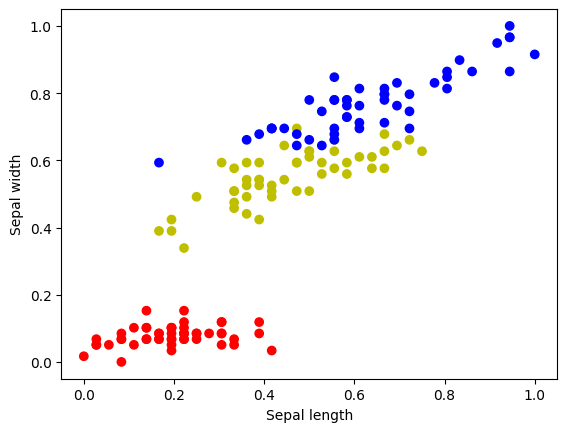

In [2]:
iris = load_iris()
X = iris.data[:,::2]  # comprimento das sépalas e pétalas, indices 0 e 2
# normalização
Xc = X - X.min(axis=0)
Xs = Xc.max(axis=0)
Xc = Xc/Xs

Y = iris.target
colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [3]:
X_tensor = torch.FloatTensor(Xc)  # Entrada é FloatTensor
Y_tensor = torch.LongTensor(Y)    # Classe é LongTensor

In [4]:
Y_tensor

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

## Construindo o modelo da rede

A saída da rede é composta por um neurônio para cada classe. A saída é denominada *scores* ou logitos:

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLogisticaRede_2_3.png)

In [5]:
model = nn.Linear(2,3)  # 2 entradas e 3 saídas

In [6]:
model.state_dict()

OrderedDict([('weight',
              tensor([[-0.2172,  0.4884],
                      [ 0.4715,  0.1713],
                      [-0.3111, -0.1708]])),
             ('bias', tensor([-0.0764,  0.2208, -0.6412]))])

### Fazendo um predict

In [7]:
out = model(Variable(X_tensor[:4,:])) # 4 amostras
out

tensor([[-0.0916,  0.3372, -0.7219],
        [-0.0795,  0.3110, -0.7047],
        [-0.0757,  0.2819, -0.6845],
        [-0.0531,  0.2746, -0.6816]], grad_fn=<AddmmBackward0>)

In [8]:
oo = F.softmax(out,dim=1)
oo

tensor([[0.3260, 0.5005, 0.1735],
        [0.3319, 0.4905, 0.1776],
        [0.3362, 0.4808, 0.1829],
        [0.3423, 0.4751, 0.1826]], grad_fn=<SoftmaxBackward0>)

### Calculando as probabilidades com Softmax

- [Wikipedia:Softmax_function](https://en.wikipedia.org/wiki/Softmax_function)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/softmax.png)

In [9]:
F.softmax(out,dim=1)*100

tensor([[32.5966, 50.0486, 17.3548],
        [33.1900, 49.0468, 17.7631],
        [33.6249, 48.0819, 18.2932],
        [34.2318, 47.5087, 18.2594]], grad_fn=<MulBackward0>)

### Predição da classe

In [10]:
prob,y_pred = torch.max(F.softmax(out,dim=1),dim=1)
print(y_pred)
print(prob)

tensor([1, 1, 1, 1])
tensor([0.5005, 0.4905, 0.4808, 0.4751], grad_fn=<MaxBackward0>)


## Treinamento

### Classe para visualização dinâmica

In [11]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

def predict_prob(model, inputs):
    outputs = model(Variable(inputs))
    outputs = F.softmax(outputs,dim=1)
    predicts, _ = torch.max(outputs, 1)

    return predicts.data.numpy()

class MyPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(12, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 3, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.set_title('Perda x Época')
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 3, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax2.set_title('Fronteiras de decisão')

        self.ax3 = self.fig.add_subplot(1, 3, 3)
        self.ax3.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax3.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax3.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax3.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax3.set_title('Máxima probabilidade')

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                #Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
                Zc = predict(self.model,torch.FloatTensor(self.X_grid))
                Zc = Zc.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Zc, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                Zp = predict_prob(self.model,torch.FloatTensor(self.X_grid))
                Zp = Zp.reshape(self.xx.shape)

                self.ax3.pcolormesh(self.xx, self.yy, Zp, cmap=plt.cm.magma)
                colors = np.array(['r','y','b'])
                self.ax3.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

### Laço principal de treinamento da Regressão Logística por Softmax

In [12]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Final loss: 0.20715562999248505


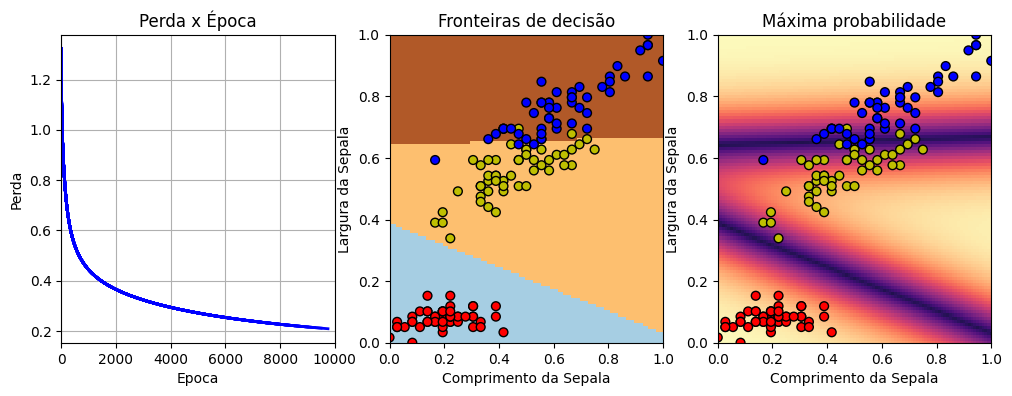

In [13]:
nb_epoch = 10000

#Definindo o plotter
my_plot = MyPlotter(model, Xc, Y, nb_epoch)

losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    # calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # Faz o backpropagation para calcular os gradientes e otimizar parâmetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data.item())

    my_plot.on_epoch_end(i, {'loss': loss.data.item()});
    final_loss = loss.data.item()

print('Final loss:', final_loss)

## Avaliação

### Parâmetros após treinamento

In [14]:
model.state_dict()

OrderedDict([('weight',
              tensor([[ -3.1683, -14.5080],
                      [  1.8042,  -0.5294],
                      [  1.3072,  15.5263]])),
             ('bias', tensor([ 6.8665,  1.4530, -8.8163]))])

### Salvando os parâmetros treinados

In [15]:
os.makedirs('../models',exist_ok=True)
torch.save(model.state_dict(),'../models/RegrLog_Iris.pt')

In [16]:
! ls ../models/

RegrLog_Iris.pt


In [17]:
nn.init.constant(model.weight,0)
model.state_dict()

<ipython-input-17-0d5512203613>:1: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  nn.init.constant(model.weight,0)


OrderedDict([('weight',
              tensor([[0., 0.],
                      [0., 0.],
                      [0., 0.]])),
             ('bias', tensor([ 6.8665,  1.4530, -8.8163]))])

### Recuperando os pesos salvos

In [18]:
param_saved = torch.load('../models/RegrLog_Iris.pt')
model.load_state_dict(param_saved)
model.state_dict()

<ipython-input-18-079748b01dc8>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  param_saved = torch.load('../models/RegrLog_Iris.pt')


OrderedDict([('weight',
              tensor([[ -3.1683, -14.5080],
                      [  1.8042,  -0.5294],
                      [  1.3072,  15.5263]])),
             ('bias', tensor([ 6.8665,  1.4530, -8.8163]))])

### Exatidão (acurácia) do classificador

Acurácia indica o número de acertos sobre o número total de amostras

In [19]:
Y_pred = predict(model, X_tensor)
accuracy = (Y_pred == Y).mean()
print('Training Accuracy: ', accuracy)

Training Accuracy:  0.96


### Matriz de confusão

In [20]:
import pandas as pd
pd.crosstab(Y_pred, Y)

col_0,0,1,2
row_0,,,
0,50,0,0
1,0,47,3
2,0,3,47


## Atividades

### Perguntas:

**1. Observe que se após o treinamento, a célula for executada novamente, ela continua utilizando os parâmetros treinados até sua última execução. O que é preciso fazer para que o treinamento comece deste o início, como da primeira vez que foi executado?**

É necessário instanciar a rede novamente para resetar os pesos.

**2. Experimente refazer o treinamento com diferentes valores de learning rate**



Final loss: 0.10745342075824738


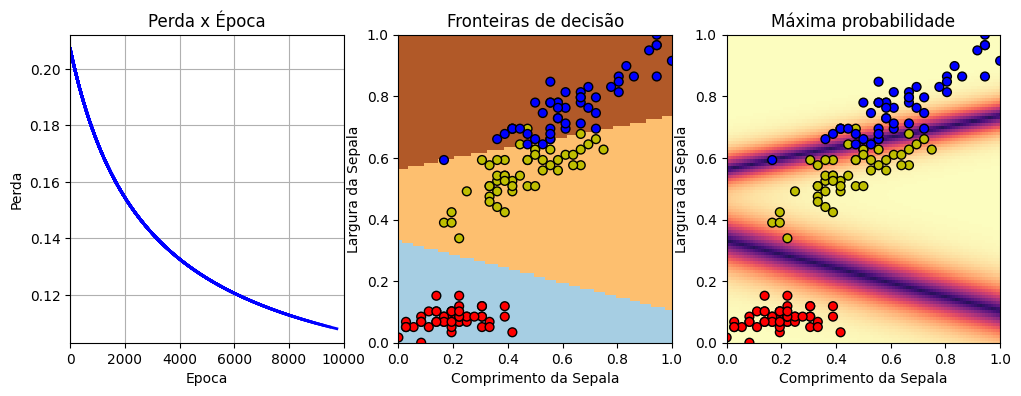

In [21]:
lr = 0.8

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
nb_epoch = 10000

#Definindo o plotter
my_plot = MyPlotter(model, Xc, Y, nb_epoch)

losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    # calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # Faz o backpropagation para calcular os gradientes e otimizar parâmetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data.item())

    my_plot.on_epoch_end(i, {'loss': loss.data.item()});
    final_loss = loss.data.item()

print('Final loss:', final_loss)

Final loss: 0.08548163622617722


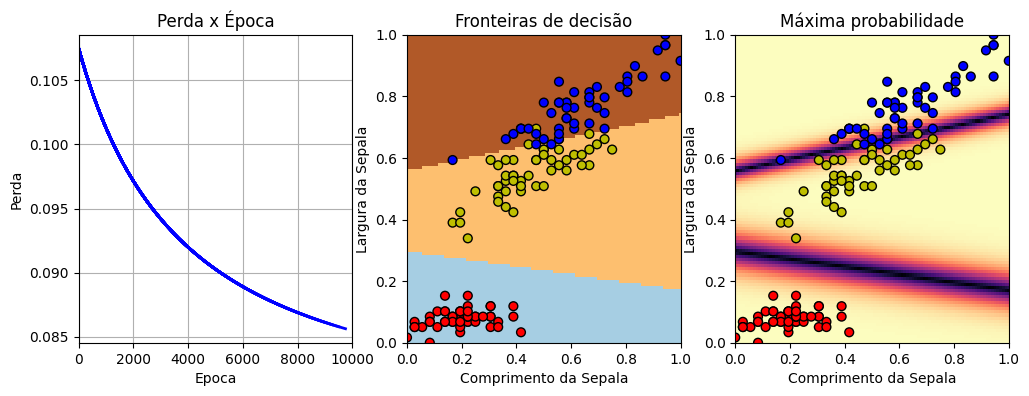

In [22]:
lr = 2.7

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
nb_epoch = 10000

#Definindo o plotter
my_plot = MyPlotter(model, Xc, Y, nb_epoch)

losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    # calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # Faz o backpropagation para calcular os gradientes e otimizar parâmetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data.item())

    my_plot.on_epoch_end(i, {'loss': loss.data.item()});
    final_loss = loss.data.item()

print('Final loss:', final_loss)

**O final Loss do lr = 0.15 foi 0.20703771710395813, do lr = 0.8 foi 011242589354515076 e do lr = 2.7 foi 0.08835319429636002.**

Os valores de Loss- função de perda representam a qualidade do modelo após o treinamento com diferentes taxas de aprendizado, learning rates-lr. A função de perda- MSELoss mede o quão bem o modelo está fazendo previsões comparadas aos valores reais. Quanto menor o valor de Loss, melhor o modelo está se ajustando aos dados.

**Final Loss do lr = 0.15 foi 0.20703771710395813**

Este valor indica que o modelo conseguiu aprender a relação entre os dados de entrada e as saídas, mas a função de perda ainda está relativamente alta.

Isso sugere que o modelo está convergindo lentamente. O valor de Loss pode ser mais alto porque o learning rate é baixo, o que faz com que o modelo faça ajustes menores a cada atualização dos pesos. Embora o modelo esteja aprendendo de forma estável, ele pode precisar de mais épocas de treinamento ou uma taxa de aprendizado maior para atingir um melhor desempenho.

**Final Loss do lr = 0.8 foi 011242589354515076**

O valor de Loss é menor em comparação com o lr = 0.15, o que indica que o modelo está se ajustando melhor aos dados. A taxa de aprendizado de 0.8 pode ser uma boa escolha, pois a função de perda diminuiu de maneira significativa, sugerindo que o modelo está aprendendo de forma eficaz.

Uma taxa de aprendizado maior permite que o modelo faça ajustes mais rápidos nos pesos, o que geralmente acelera o aprendizado, mas também pode levar a um modelo que "pule" o ótimo global se a taxa for muito alta.

**Final Loss do lr = 2.7 foi 0.08835319429636002**

o valor da função de perda é ainda mais baixo em comparação com os outros dois casos, o que poderia indicar que o modelo teve um bom desempenho e está fazendo boas previsões. Entretanto, é bom tomar cuidado com conclusões rápidas, uma taxa de aprendizado muito alta pode levar a instabilidade em certos casos, ou seja, os pesos podem começar a oscilar de maneira descontrolada, pulando o ponto ótimo do gradiente descendente.

O fato da Loss ser baixa sugere que a taxa de aprendizado foi boa para ajustar bem os parâmetros, mas pode ser necessário monitorar o comportamento do modelo em outras iterações para garantir que ele não esteja sobreajustando ou se aproximando de um ponto de instabilidade.

### Exercícios:

1. Observando o gráfico de máxima probabilidade, responda:
    1. Qual é a amostra classificada corretamente, com maior probabilidade?
    2. Qual é a amostra classificada erradamente, com maior probabilidade?
    3. Qual é a amostra classificada corretamente, com menor probabilidade?
    4. Qual é a amostra classificada erradamente, com menor probabilidade?
2. Quantos parâmetros possui esta rede? Quantos são da camada densa e quantos são de bias?
3. Quantas entradas e quantas saídas esta rede possui?
4. Como se pode calcular a acurácia a partir da matriz de confusão?
5. O que faz a função `torch.max`? Quantos parâmetros ela retorna e quais seus significados?
    - http://pytorch.org/docs/master/torch.html?highlight=torch%20max#torch.max

Primeira Questão
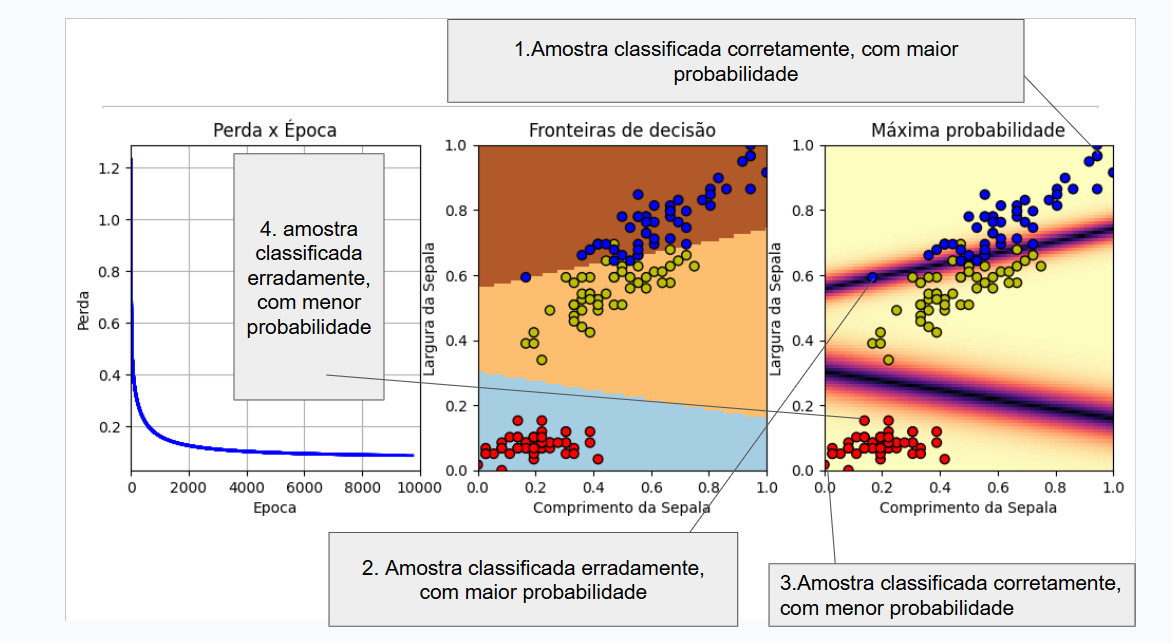

**2 Questão**

**Quantos parâmetros possui esta rede? Quantos são da camada densa e quantos são de bias?**

Considerando a rede exposta aqui:

model = nn.Linear(2,3)  # 2 entradas e 3 saídas
model.state_dict()

OrderedDict([('weight',
              tensor([[-0.1810, -0.0055],
                      [ 0.0202,  0.5731],
                      [-0.1259, -0.6639]])),
             ('bias', tensor([ 0.5780, -0.1746, -0.1117]))])

**Camada de pesos (weight):**

A variável weight contém um tensor de tamanho 3 x 2, ou seja, 3 linhas e 2 colunas.
Isso significa que existem 3 neurônios na camada de saída (ou unidades na camada densa) e 2 entradas para cada neurônio, o que sugere que a rede tem 2 características de entrada.
Portanto, a camada de pesos tem 3 * 2 = 6 parâmetros.

**Camada de viés (bias):**

A variável bias contém um tensor de tamanho 3, ou seja, 1 valor de viés para cada neurônio da camada de saída.
Portanto, há 3 parâmetros de viés, um para cada neurônio na camada de saída.

**Resumo dos parâmetros:**
Parâmetros de pesos: A camada densa tem 6 parâmetros (3 neurônios * 2 entradas).
Parâmetros de viés: A camada de viés tem 3 parâmetros (1 viés por neurônio).
Total de parâmetros:
Parâmetros totais = 6 (pesos) + 3 (viés) = 9 parâmetros no total.

**Conclusão:**
A rede possui 9 parâmetros no total:
6 parâmetros de pesos (para a camada densa),
3 parâmetros de viés (um para cada neurônio de saída).

**Observação final:**

Uma camada densa (ou camada totalmente conectada) é um tipo de camada de rede neural onde cada neurônio está conectado a todos os neurônios da camada anterior. Esse tipo de camada é chamado de "densa" porque há uma conexão direta entre todos os neurônios de uma camada e todos os neurônios da camada seguinte.

Enfim, na camada densa, cada neurônio de entrada é alimentado a todos os neurônios da camada seguinte. Cada neurônio da camada densa possui um peso associado a cada entrada, e um viés associado a ele.



**3. Quantas entradas e quantas saídas esta rede possui?**

Como dito anteriormente, esta rede possui 2 entradas e 3 saídas.

**4. Como se pode calcular a acurácia a partir da matriz de confusão?**

A acurácia é calculada como a razão entre o número total de previsões corretas e o número total de previsões feitas. Ou seja, a fórmula para a acurácia é Verdadeiros Positivos + Verdadeiros Negativos/ Total de Exemplos.

Na matriz de confusão exposta, para verificar a acurácia se deve calcular o número total de acertos. Os acertos estão na diagonal principal. Depois calcular o número total de exemplos. Para isso, somamos todos os valores na matriz.

50 0	0

0	47	2

0	3	48

Portanto, acertos = 50+47+48 =145;  número total de exemplos = 50 + 47+2+3+48 =150;acurácia = 145/150 =0.9667 ou 96.67%.




**4.O que faz a função torch.max? Quantos parâmetros ela retorna e quais seus significados?**


A função torch.max no PyTorch é usada para encontrar o valor máximo ao longo de um tensor ou ao longo de uma dimensão específica de um tensor e pode ser aplicada de várias maneiras. Dependendo de como é chamada, ela pode retornar diferentes tipos de resultados.
- Quando aplicada a um único tensor, torch.max retorna o valor máximo em todo o tensor.
-Quando aplicada a dois tensores do mesmo tamanho, torch.max(input, other) retorna um tensor onde cada elemento é o maior entre os elementos correspondentes dos dois tensores.
-Quando aplicada a uma dimensão específica, torch.max retorna dois parâmetros:
O valor máximo ao longo da dimensão especificada. E o índice do valor máximo ao longo dessa dimensão. O valor máximo é o maior valor encontrado ao longo da dimensão especificada; e o Índice do valor máximo é a posição (índice) do valor máximo ao longo da dimensão.

Enfim,

torch.max(input) retorna um único parâmetro: o valor máximo de todo o tensor.

torch.max(input, other) retorna um tensor com os maiores valores entre os dois tensores de entrada.

torch.max(input, dim, keepdim=False) retorna dois parâmetros: values e índices, como dito anteriormente.

## Principais aprendizados

Neste trabalho, foram realizadas a importação de bibliotecas, a leitura e normalização dos dados, além da construção de um modelo de rede. O processo incluiu a implementação da função predict, o cálculo das probabilidades utilizando softmax e a predição da classe correspondente.  

O treinamento foi conduzido com a criação de uma classe para visualização dinâmica e a estruturação do laço de treinamento aplicado à regressão logística utilizando softmax.  

Em seguida, foi realizada a avaliação do modelo, que incluiu a identificação dos parâmetros após o treinamento, o salvamento dos pesos ajustados, a recuperação desses parâmetros, e a análise de desempenho por meio da acurácia e da matriz de confusão.  

Na etapa dos exercícios, foram resolvidas diversas questões, possibilitando um estudo mais aprofundado e análises detalhadas.